In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy
import torch.nn.functional as F
import copy
from sklearn.metrics import roc_auc_score, average_precision_score
from torch import nn
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv
from torch.nn import Module, Parameter

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Variational Graph AutoEncoder

In [3]:
def sparse_degree_matrix(A) -> torch.sparse.FloatTensor:
    D = scipy.sparse.spdiags(torch.sparse.sum(A, dim=1).to_dense(),0, *A.shape).tocoo()
    return coo_to_torch_sparse_matrix(D)

In [4]:
def coo_to_torch_sparse_matrix(coo):
    idx = torch.LongTensor(coo.nonzero())
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(idx, data)

In [5]:
def laplacian(A, normalized=True):
    I = torch.eye(A.shape[0])
    D = sparse_degree_matrix(A)
    if not normalized:
        L = D.sub(A)
    else:
        D = (D**(-0.5)).to_dense()
        p1 = torch.spmm(A, D)
        L = torch.mm(p1, D)
        # L = coo_to_torch_sparse_matrix(scipy.sparse.coo_matrix(I - p2))

    return L

In [6]:
M_test = torch.sparse.FloatTensor(data.edge_index, torch.FloatTensor(np.repeat(1, len(data.edge_index[1]))))
L = laplacian(M_test)
# L = torch.from_numpy(np.load('imported_A.npy'))

In [7]:
def get_acc (adj_rec, adj_label) -> float:
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy

def get_roc_auc_score (adj_rec, adj_label) -> float:
    print("Rec ", adj_rec[0][0].detach(), "\tOrig ", adj_label[0][0], sep='')
    labels_all = adj_label.view(-1).long()
    preds_all = adj_rec.view(-1).long()
    return roc_auc_score(labels_all, preds_all)
    
def get_ap_score (adj_rec, adj_label) -> float:
    labels_all = adj_label.view(-1).long()
    preds_all = adj_rec.view(-1).long()
    return average_precision_score(labels_all, preds_all)

In [8]:
def glorot_init(input_dim, output_dim) -> Parameter:
    init_range = np.sqrt(6.0/(input_dim + output_dim))
    initial = torch.rand(input_dim, output_dim)*2*init_range - init_range
    return Parameter(initial)

In [9]:
class GraphConvolutionLayer(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.weight = glorot_init(in_features, out_features)
        
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output # + self.bias

In [13]:
class VGAE(Module):
    def __init__(self, nfeat, nhid, dimz, n_samples):
        super(VGAE, self).__init__()
        self.n_samples = n_samples
        self.nhid = nhid
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2mu = GraphConvolutionLayer(nhid, dimz)
        self.gc2std = GraphConvolutionLayer(nhid, dimz)
        
    def encode(self, x, adj):
        # First GCN
        x = self.gc1(x, adj)
        # Mean and std
        self.mean = self.gc2mu(x, adj)
        self.log_std = self.gc2std(x, adj)
        # Latent representation
        return torch.exp(self.log_std) * torch.randn(*self.log_std.size()) + self.mean
        
    def decode(self, z):
        return torch.sigmoid(torch.matmul(z, z.t()))
        
    def forward(self, x, adj):
        z = self.encode(x, adj)
        A_recon = self.decode(z)
        return A_recon
    
    def loss(self, A_hat, A, norm, weight_tensor):
        # Binary Crossentropy loss
        # bce_loss = nn.BCELoss(reduce='sum')(A_hat, A)
        bce_loss = norm * F.binary_cross_entropy(A_hat.view(-1), A.view(-1), weight = weight_tensor)
        # KL Loss
        # kl_loss = - 0.5 * torch.mean(torch.sum(1 + self.log_std - self.mean.pow(2) - self.log_std.exp(), dim=1)) 
        # kl_loss = nn.KLDivLoss(reduce='batchmean')(torch.log(A_hat), A)
        kl_loss = 0.5/ A_hat.size(0) * (1 + 2*self.log_std - self.mean.pow(2) - torch.exp(self.log_std).pow(2)).sum(1).mean()
        
        return bce_loss - kl_loss
        

In [14]:
vgae = VGAE(1433, 32, 16, data.x.shape[0])
optimizer = optim.Adam(vgae.parameters(), lr=0.01)

pos_weight = float(L.shape[0] * L.shape[0] - L.sum()) / L.sum()
norm = L.shape[0] * L.shape[0] / float((L.shape[0] * L.shape[0] - L.sum()) * 2)
# L += torch.eye(*L.shape)
weight_mask = L.view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

In [15]:
import tqdm
loss_history = np.zeros(200) 

for epoch in tqdm.trange(200): 
  
    optimizer.zero_grad()
    # A_hat = vgae(torch.eye(*data.x.shape), L)
    A_hat = vgae(data.x, L)
    loss = vgae.loss(A_hat, L, norm, weight_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0: 
        print("Accuracy: " + str(get_acc(A_hat, L).detach()) + 
              "\tROC AUC score: " + str(get_roc_auc_score(A_hat, M_test.to_dense())) +
              "\tAP score: " + str(get_ap_score(A_hat, M_test.to_dense()))
             )

    loss_history[epoch] = loss.detach().numpy()

  0%|          | 0/200 [00:00<?, ?it/s]

Rec tensor(1.)	Orig tensor(0.)


  0%|          | 1/200 [00:03<11:43,  3.53s/it]

Accuracy: tensor(0.4963)	ROC AUC score: 0.5090135784923551	AP score: 0.0018764116671314414


 25%|██▌       | 50/200 [00:19<00:45,  3.29it/s]

Rec tensor(0.7228)	Orig tensor(0.)


 26%|██▌       | 51/200 [00:22<02:40,  1.08s/it]

Accuracy: tensor(0.4896)	ROC AUC score: 0.49999986343849845	AP score: 0.001439468154971647


 50%|█████     | 100/200 [00:36<00:32,  3.07it/s]

Rec tensor(0.8292)	Orig tensor(0.)


 50%|█████     | 101/200 [00:39<01:52,  1.14s/it]

Accuracy: tensor(0.4723)	ROC AUC score: 0.49999986343849845	AP score: 0.001439468154971647


 75%|███████▌  | 150/200 [00:55<00:16,  3.00it/s]

Rec tensor(0.9184)	Orig tensor(0.)


 76%|███████▌  | 151/200 [00:58<01:01,  1.25s/it]

Accuracy: tensor(0.4889)	ROC AUC score: 0.4999997268769969	AP score: 0.001439468154971647


100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


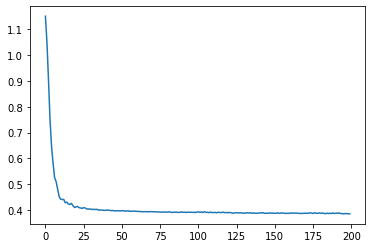

1.1495308876037598
0.38592711091041565
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2500, 0.0000]])
tensor([[0.9379, 0.5728, 0.6636,  ..., 0.5226, 0.6639, 0.5218],
        [0.5728, 0.9919, 0.9693,  ..., 0.0963, 0.4516, 0.4084],
        [0.6636, 0.9693, 0.9392,  ..., 0.2121, 0.4718, 0.4385],
        ...,
        [0.5226, 0.0963, 0.2121,  ..., 0.9855, 0.5712, 0.4438],
        [0.6639, 0.4516, 0.4718,  ..., 0.5712, 0.6544, 0.5269],
        [0.5218, 0.4084, 0.4385,  ..., 0.4438, 0.5269, 0.5645]])


In [16]:
plt.plot(loss_history)
plt.show()
print(loss_history[0])
print(loss_history[len(loss_history) -1])
print(L, A_hat.data, sep='\n')

## GCN vs VGAE

In [ ]:
def test(model, A):
    model.eval()
    _, pred = model(data.x, A).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [ ]:
class GCN(Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [ ]:
VGAE_A = A_hat.data.clone()
VGAE_A = (VGAE_A > 0.5).float()

In [ ]:
gcn1 = GCN(1433, 50, 7)
gcn2 = GCN(1433, 50, 7)
optimizer_gcn_1 = optim.Adam(gcn1.parameters())
optimizer_gcn_2 = optim.Adam(gcn2.parameters())
criterion = nn.CrossEntropyLoss()

### GCN

In [ ]:
del loss_history, loss

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_1.zero_grad()
    outputs = gcn1(data.x, L) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_1.step()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
print(loss_history[len(loss_history) -1])
test(gcn1, L)

### VGAE

In [ ]:
del loss_history, loss

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_2.zero_grad()
    outputs = gcn2(data.x, VGAE_A) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_2.step()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
print(loss_history[len(loss_history) -1])
test(gcn2, VGAE_A)